On va maintenant utiliser une image naturelle comme entrée. 

At each time, the pipeline is the  following:

* take an image, 
* turn into blocks corresponding to the edges' centers,
* into each block determine the most likely orientation

<!-- TEASER_END -->

Let's first create a dummy movie:

In [1]:
import os
import matplotlib
matplotlib.use("Agg") # agg-backend, so we can create figures without x-server (no PDF, just PNG etc.)
from EdgeGrid import EdgeGrid
e = EdgeGrid()
fps = 24.
loop = 1
autoplay = 0
duration = 4.
figpath = '../files/figures/elasticite/'

In [2]:
import matplotlib as mpl
import matplotlib.pyplot as plt
from moviepy.video.io.bindings import mplfig_to_npimage
import moviepy.editor as mpy

fig_mpl, ax = plt.subplots(1, figsize=(1, 1), facecolor='white')

def draw_elementary_pattern(ax, center): 
    #ax.add_artist(mpl.patches.Wedge(center-1., 1., 0, 180, width=.1)) #center, r, theta1, theta2, width=None
    #ax.add_artist(mpl.patches.Wedge(-center+1., 1., 0, 180, width=.1))
    # class matplotlib.patches.RegularPolygon(xy, numVertices, radius=5, orientation=0, **kwargs)¶
    ax.add_artist(mpl.patches.RegularPolygon((.5,.5), 5, center, facecolor='r'))
    ax.add_artist(mpl.patches.RegularPolygon((.5,.5), 5, center/2, facecolor='w'))
    ax.add_artist(mpl.patches.RegularPolygon((.5,.5), 5, center/4, facecolor='g'))

def make_frame_mpl(t):
    ax = fig_mpl.add_axes([0., 0., 1., 1.], axisbg='w')
    ax.cla()
    plt.setp(ax, xticks=[])
    plt.setp(ax, yticks=[])
    #ax.axis(c='b', lw=0, frame_on=False)
    ax.grid(b=False, which="both")
    draw_elementary_pattern(ax, t/duration)
    return mplfig_to_npimage(fig_mpl) # RGB image of the figure

animation = mpy.VideoClip(make_frame_mpl, duration=duration)

In [3]:
name, vext = 'elasticite_test', '.mp4'
if not os.path.isfile(os.path.join(figpath, name + '.webm')):
    animation.write_videofile(figpath + name + vext, fps=fps)
    animation.write_videofile(figpath + name + e.vext, fps=fps)
e.ipython_display(name)

""


Now read this clip using ``imageio``:

In [4]:
import imageio

reader = imageio.get_reader(figpath + name + vext)
for i, im in enumerate(reader):
    print('Mean of frame %i is %1.1f' % (i, im.mean()))
    if i > 15: break

Mean of frame 0 is 253.0
Mean of frame 1 is 253.0
Mean of frame 2 is 252.9
Mean of frame 3 is 252.8
Mean of frame 4 is 252.5
Mean of frame 5 is 252.2
Mean of frame 6 is 251.9
Mean of frame 7 is 251.3
Mean of frame 8 is 250.8
Mean of frame 9 is 250.3
Mean of frame 10 is 249.7
Mean of frame 11 is 248.9
Mean of frame 12 is 248.1
Mean of frame 13 is 247.2
Mean of frame 14 is 246.2
Mean of frame 15 is 245.2
Mean of frame 16 is 244.2


Let's consider one frame, and a ROI defined by its center and width:

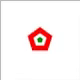

In [5]:
def mat2ipn(mat):   
    # create a temporary file
    import tempfile
    filename = tempfile.mktemp(suffix='.png')
    # Use write_png to export your wonderful plot as png ! 
    import vispy.io as io
    imageio.imwrite(filename, mat)
    from IPython.core.display import display, Image
    return display(Image(filename))    
mat2ipn(im)
#from holoviews import Image
#from holoviews import HoloMap, Dimension
#%load_ext holoviews.ipython

## trying to guess orientations using LogGabors

In [6]:
from NeuroTools.parameters import ParameterSet
from SLIP import Image
slip = Image(ParameterSet({'N_X':im.shape[1], 'N_Y':im.shape[0]}))

(80, 80)


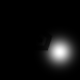

In [7]:
import numpy as np
im_ = im.sum(axis=-1)
print(im_.shape)

X_=.3
Y_=.5
w=.2
im_ = im_ * np.exp(-.5*((slip.x-X_)**2+(slip.y-Y_)**2)/w**2)
mat2ipn(im_)

Now, we will test the energy of different orientations :

In [8]:
from LogGabor import LogGabor
lg = LogGabor(slip)
N_theta = 24
thetas, E = np.linspace(0, np.pi, N_theta), np.zeros((N_theta,))
for i_theta, theta in enumerate(thetas):
    params= {'sf_0':.3, 'B_sf': .3, 'theta':theta, 'B_theta': .1}
    FT_lg = lg.loggabor(0, 0, **params)
    E[i_theta] = np.sum(np.absolute(slip.FTfilter(im_.T, FT_lg, full=True))**2)
    print(theta*180/np.pi, E[i_theta])       

0.0 191419.601564
7.82608695652 364462.836566
15.652173913 876023.302627
23.4782608696 686848.523021
31.3043478261 189899.258744
39.1304347826 51490.320886
46.9565217391 34729.345903
54.7826086957 33399.3426112
62.6086956522 30688.4672712
70.4347826087 35737.5205802
78.2608695652 64397.6882788
86.0869565217 102387.203714
93.9130434783 100155.752942
101.739130435 52189.609773
109.565217391 34468.1798847
117.391304348 40474.7223414
125.217391304 39320.6605892
133.043478261 31581.6734211
140.869565217 24044.5673182
148.695652174 25072.6964592
156.52173913 36171.3414746
164.347826087 47962.6963015
172.173913043 82461.0904895
180.0 190978.180492


Now select the most likely:

In [9]:
print(np.argmax(E), thetas[np.argmax(E)]*180/np.pi)

2 15.652173913


wrapping things in one function:

In [10]:
from NeuroTools.parameters import ParameterSet
from SLIP import Image
from LogGabor import LogGabor
import numpy as np
slip = Image(ParameterSet({'N_X':im.shape[1], 'N_Y':im.shape[0]}))
lg = LogGabor(slip)
N_theta = 24
def theta_max(im, X_=.0, Y_=.0, w=.3):
    im_ = im.sum(axis=-1)
    im_ = im_ * np.exp(-.5*((slip.x-X_)**2+(slip.y-Y_)**2)/w**2)
    thetas, E = np.linspace(0, np.pi, N_theta), np.zeros((N_theta,))
    for i_theta, theta in enumerate(thetas):
        params= {'sf_0':.3, 'B_sf': .3, 'theta':theta, 'B_theta': .1}
        FT_lg = lg.loggabor(0, 0, **params)
        E[i_theta] = np.sum(np.absolute(slip.FTfilter(im_.T, FT_lg, full=True))**2)
    return np.pi/2 - thetas[np.argmax(E)]     

e.reader = imageio.get_reader(figpath + 'elasticite_test.mp4', loop=True)
for i, im in enumerate(reader):
    print(i, theta_max(im, X_=.3, Y_=.3, w=.3)*180./np.pi)
    if i > 5: break

0 90.0
1 90.0
2 90.0
3 90.0
4 90.0
5 90.0
6 -3.91304347826


We retrieve the centers and span of all edges from the ``EdgeGrid`` class:

In [11]:
name = 'trame_loggabor'
import numpy as np
from EdgeGrid import EdgeGrid
e = EdgeGrid()

import imageio
e.reader = imageio.get_reader(figpath + 'elasticite_test.mp4', loop=True)
def make_lames(e):
    im = e.reader.get_next_data()
    for i in range(e.N_lame):
        e.lames[2, i] = e.theta_max(im, X_=e.lames[0, i], Y_=e.lames[1, i], w=.05)
    return e.lames[2, :]

e.make_anim(name, make_lames, duration=duration)
e.ipython_display(name)

""


## trying to guess orientations using Sobel filters

dans ce cas, on voit que les filtres orientés sont corrects, mais c'est un peu overkill (et lent) donc on peut préférer utiliser des filtres orientés plus simples, les filtres de Sobel, soit pour les horizontales la matrice:

    [1   2  1]
    [0   0  0]
    [-1 -2 -1]    
    
et son transposé (pour les verticales). 

In [12]:
name = 'trame_sobel_orientations'
if not os.path.isfile(os.path.join(figpath, name + '.webm')):
    from EdgeGrid import EdgeGrid
    e = EdgeGrid()

    import imageio
    e.reader = imageio.get_reader(figpath + 'elasticite_test.mp4', loop=True)

    import matplotlib.pyplot as plt
    import numpy as np
    from moviepy.video.io.bindings import mplfig_to_npimage
    import moviepy.editor as mpy

    # DRAW A FIGURE WITH MATPLOTLIB
    fps = 24.
    duration = 4.
    fig_mpl, ax = plt.subplots(1, 2, figsize=(10,5), facecolor='white')
    def make_frame_mpl(t):
        import numpy as np
        sobel = np.array([[1,   2,  1,],
                          [0,   0,  0,],
                          [-1, -2, -1,]])
        im = e.reader.get_next_data()

        im_ = im.sum(axis=-1)
        from scipy.signal import convolve2d
        #im_ = im_ * np.exp(-.5*((slip.x-X_)**2+(slip.y-Y_)**2)/w**2)
        ax[0].imshow(convolve2d(im_, sobel, 'same'))
        ax[1].imshow(convolve2d(im_, sobel.T, 'same'))
        return mplfig_to_npimage(fig_mpl) # RGB image of the figure

    animation = mpy.VideoClip(make_frame_mpl, duration=duration)
    animation.write_videofile(os.path.join(figpath, name + '.webm'), fps=fps)
e.ipython_display(name)

""


The angle is derived as the arctan of the 2 components

In [13]:
name = 'trame_sobel_orientation'
import os
if True or not os.path.isfile(os.path.join(figpath, name + '.webm')):
    from EdgeGrid import EdgeGrid
    e = EdgeGrid()

    import imageio
    e.reader = imageio.get_reader(figpath + 'elasticite_test.mp4', loop=True)

    import matplotlib.pyplot as plt
    import numpy as np
    from moviepy.video.io.bindings import mplfig_to_npimage
    import moviepy.editor as mpy

    # DRAW A FIGURE WITH MATPLOTLIB
    fps = 24.
    duration = 4.
    
    
    def make_frame_mpl(t):
        fig_mpl, ax = plt.subplots(figsize=(5,5), facecolor='white')

        import numpy as np
        sobel = np.array([[1,   2,  1],
                          [0,   0,  0],
                          [-1, -2, -1]])
        im = e.reader.get_next_data()

        im_ = im.sum(axis=-1)
        N_X, N_Y = im_.shape
        x, y = np.mgrid[0:1:1j*N_X, 0:1:1j*N_Y]
        # mask = np.exp(-.5*((x-.5)**2+(y-.5)**2)/.1**2)       
        blur = np.array([[1, 2, 1],
                         [1, 8, 2],
                         [1, 2, 1]])

        from scipy.signal import convolve2d
        im_X = convolve2d(im_, sobel, 'same')
        im_Y = convolve2d(im_, sobel.T, 'same')
        for i in range(10):
            im_X = convolve2d(im_X, blur, 'same')
            im_Y = convolve2d(im_Y, blur, 'same')
        mappable = ax.imshow(np.arctan2(im_Y, im_X)*180/np.pi, origin='lower')
        fig_mpl.colorbar(mappable)
        return mplfig_to_npimage(fig_mpl) # RGB image of the figure

    animation = mpy.VideoClip(make_frame_mpl, duration=duration)
    animation.write_videofile(os.path.join(figpath, name + '.webm'), fps=fps)
e.ipython_display(name)

[MoviePy] >>>> Building video ../files/figures/elasticite/trame_sobel_orientation.webm
[MoviePy] Writing video ../files/figures/elasticite/trame_sobel_orientation.webm
[MoviePy] Done.
[MoviePy] >>>> Video ready: ../files/figures/elasticite/trame_sobel_orientation.webm 



""


This function is included in the ``EdgeGrid`` class:

In [14]:
from EdgeGrid import EdgeGrid
e = EdgeGrid()
import numpy as np
np.set_printoptions(precision=2, suppress=True)
import imageio
e.reader = imageio.get_reader(figpath + 'elasticite_test.mp4', loop=True)
for i, im in enumerate(e.reader):
    print(i, e.theta_sobel(im, N_blur=10)*180/np.pi)
    if i>5: break

0 [ -37.91    0.      0.      0.      0.      0.      0.      0.    -90.
  -90.    -90.    -90.    -90.    -90.    -90.   -227.9   -90.    -90.
  -90.    -90.    -90.    -90.    -90.     86.93  -90.    -90.    -90.
  -90.    -90.    -90.    -90.     39.17  -90.    -90.    -90.    -90.
  -90.    -90.    -90.    -90.    -90.    -90.    -90.    -90.    -90.
  -90.    -90.   -270.    -90.    -90.    -90.    -90.    -90.    -90.
  -90.    -90.    -90.    -90.    -90.    -90.    -90.    -90.    -90.
   89.97  -90.    -90.    -90.    -90.    -90.    -90.    -90.    -90.  ]
1 [ -37.91    0.      0.      0.      0.      0.      0.      0.    -90.
  -90.    -90.    -90.    -90.    -90.    -90.   -234.78  -90.    -90.
  -90.    -90.    -90.    -90.    -90.     87.01  -90.    -90.   -224.75
 -191.01 -168.09 -130.6   -90.     45.28  -90.    -90.   -259.33 -233.93
 -172.51 -118.15  -90.    -90.    -90.    -90.     83.8    57.78  -59.95
  -79.82  -90.   -270.    -90.    -90.     57.53   40.15   -1.26

In [15]:
name = 'trame_sobel'
from EdgeGrid import EdgeGrid
e = EdgeGrid()

import imageio
e.reader = imageio.get_reader(figpath + 'elasticite_test.mp4', loop=True)
def make_lames(e):
    e.im = e.reader.get_next_data()
    return e.theta_sobel(e.im, N_blur=10)

duration = 4.
e.make_anim(name, make_lames, duration=duration)
e.ipython_display(name)

""


In [16]:
import imagen as ig
line=ig.Line(xdensity=5, ydensity=5, smoothing=0)
import numpy as np
np.set_printoptions(1)
import holoviews
%reload_ext holoviews.ipython

:NdLayout   [Time]
   :Image   [x,y]   (z)
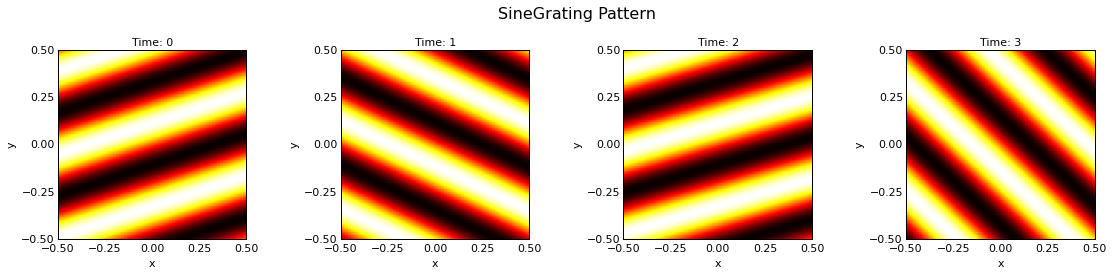

In [17]:
import numbergen as ng
from holoviews import NdLayout
import param
param.Dynamic.time_dependent=True
stim = ig.SineGrating(orientation=np.pi*ng.UniformRandom())
NdLayout(stim.anim(3))

In [18]:
name = 'trame_sobel_grating'
from EdgeGrid import EdgeGrid
e = EdgeGrid()
stim = ig.SineGrating(xdensity=64, ydensity=64)
def make_lames(e):
    stim.orientation=np.pi*e.t/4.
    e.im = stim()
    return e.theta_sobel(e.im, N_blur=5)

duration = 4.
e.make_anim(name, make_lames, duration=duration)
e.ipython_display(name)

""


:Layout
   .Pattern.Line.I    :HoloMap   [Time]
      :Image   [x,y]   (z)
   .Pattern.Line.II   :HoloMap   [Time]
      :Image   [x,y]   (z)
   .Pattern.Composite :HoloMap   [Time]
      :Image   [x,y]   (z)
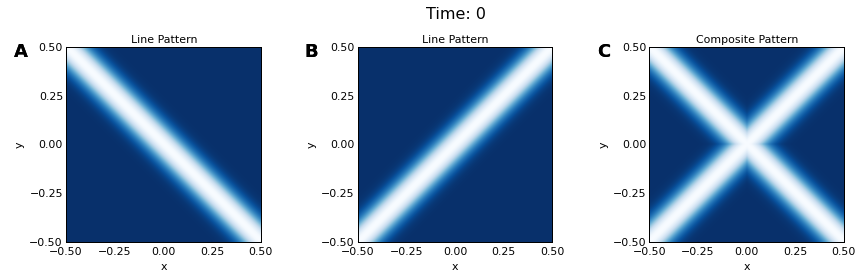
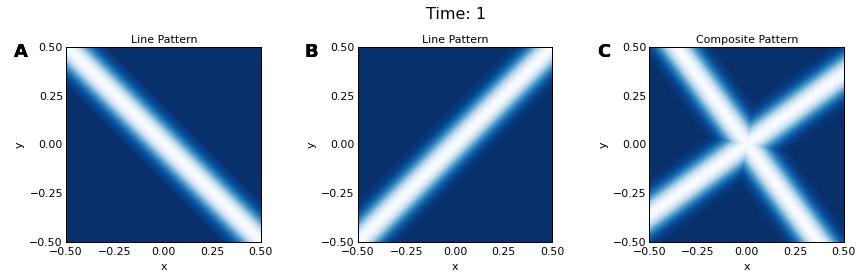
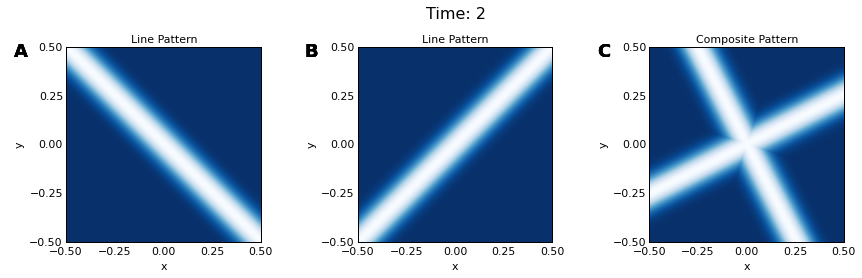
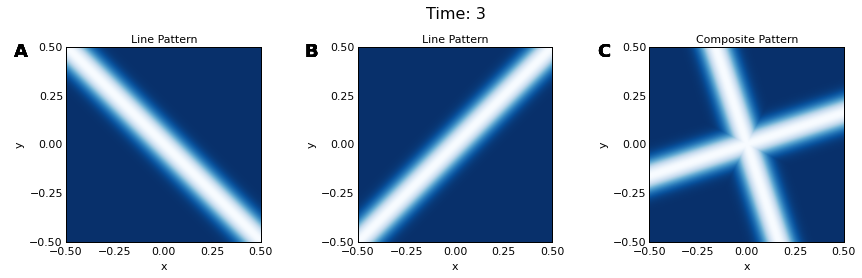
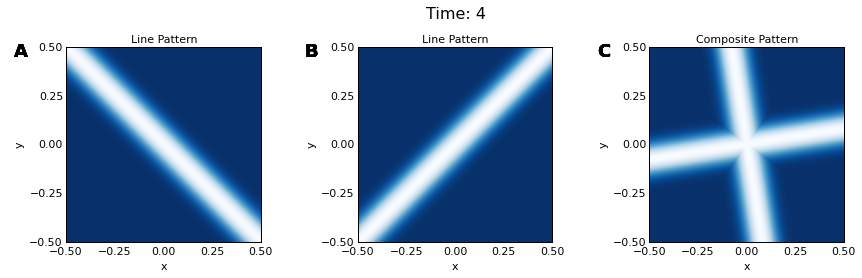
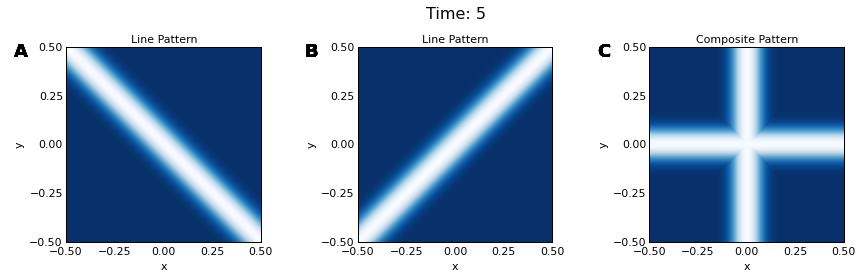
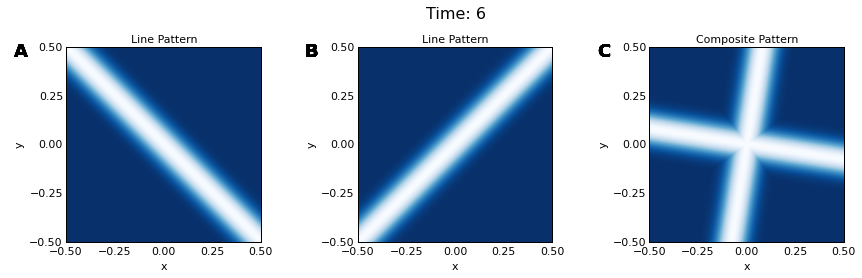
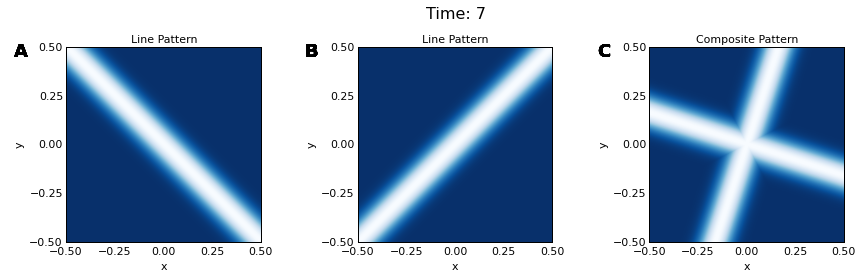
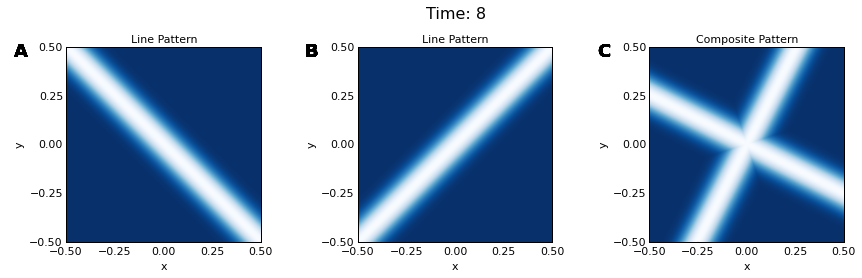
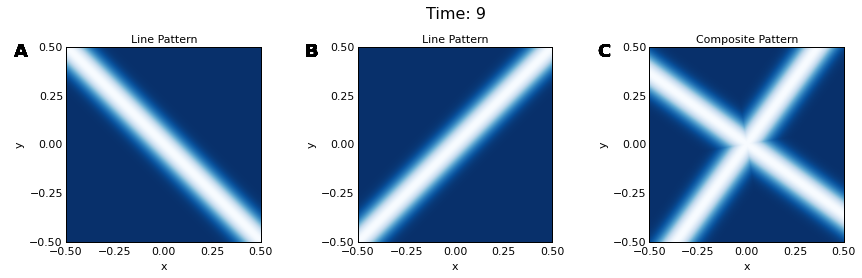
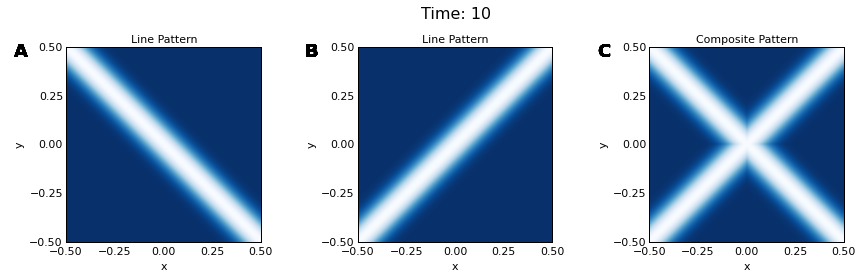
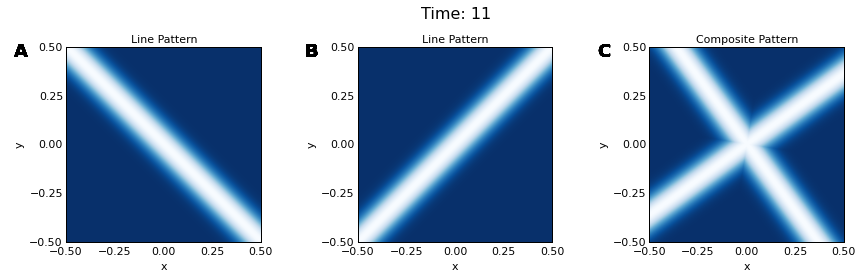
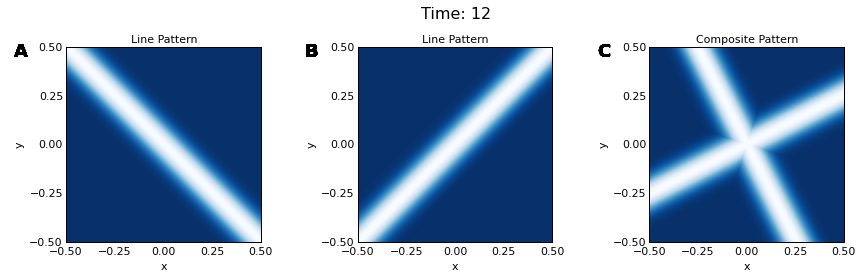
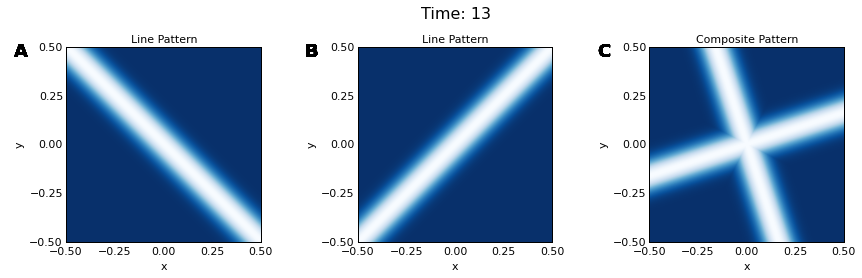
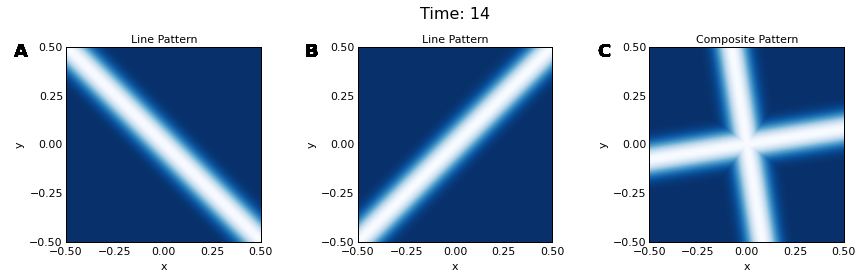
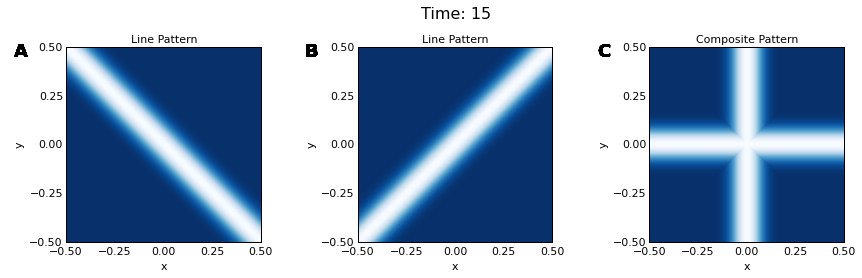
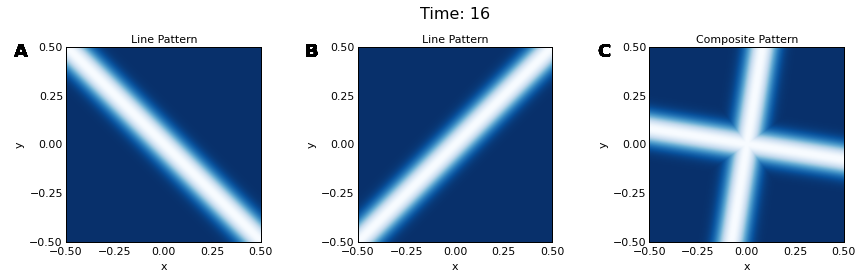
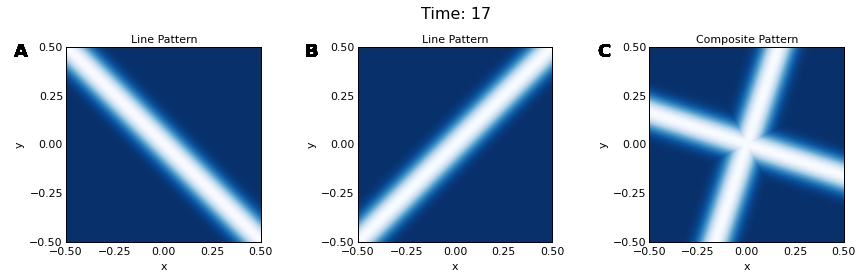
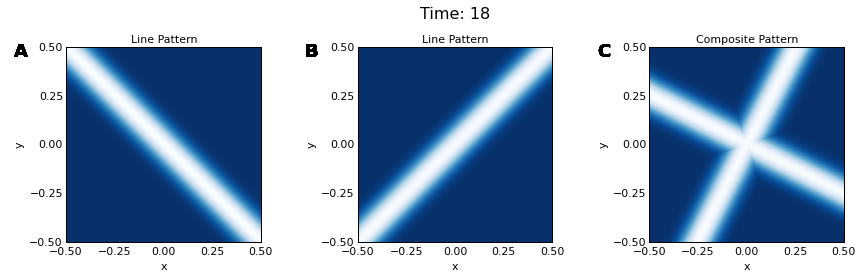
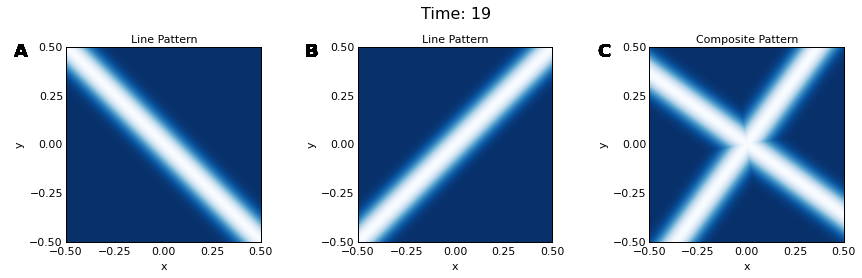
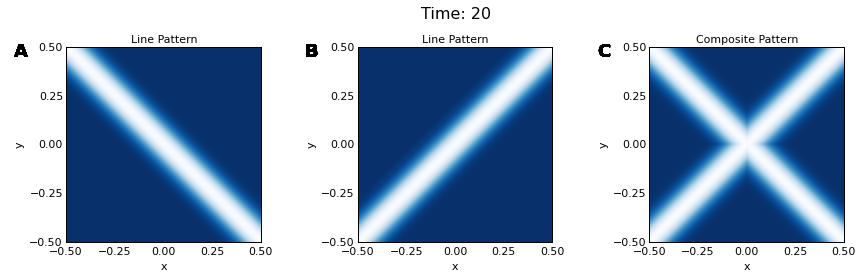

In [19]:
%%opts Image.Pattern (cmap='Blues_r')
l1 = ig.Line(orientation=-np.pi/4)
l2 = ig.Line(orientation=+np.pi/4)
cross = l1 | l2
cross.orientation=ng.ScaledTime()*(np.pi/-20)
l1.anim(20) + l2.anim(20) + cross.anim(20)

In [20]:
name = 'trame_sobel_cross'
from EdgeGrid import EdgeGrid
e = EdgeGrid()
l1 = ig.Line(orientation=-np.pi/4)
l2 = ig.Line(orientation=+np.pi/4)
cross = l1 | l2

def make_lames(e):
    cross.orientation = np.pi*e.t/4.
    e.im = cross()
    return e.theta_sobel(e.im, N_blur=1)

duration = 4.
e.make_anim(name, make_lames, duration=duration)
e.ipython_display(name)

""


:NdLayout   [Time]
   :Image   [x,y]   (z)
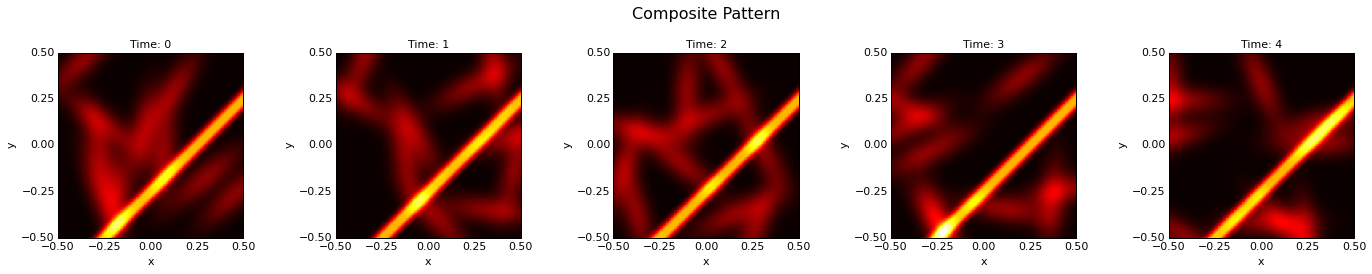

In [21]:
line.set_param(xdensity=72,ydensity=72,orientation=np.pi/4, thickness=0.02, smoothing=0.02)
line.x = .25

noise = ig.Composite(xdensity=72, ydensity=72,
                     operator=np.add,
                     generators=[ig.Gaussian(size=0.1,
                                          x=ng.UniformRandom(seed=i+1)-0.5,
                                          y=ng.UniformRandom(seed=i+2)-0.5,
                                          orientation=np.pi*ng.UniformRandom(seed=i+3))
                                for i in range(10)])

stim = line + 0.3*noise
NdLayout(stim.anim(4)).cols(5)

In [22]:
name = 'trame_sobel_line_tmp_4'
from EdgeGrid import EdgeGrid
e = EdgeGrid()

def make_lames(e):
    line.x = -.5 + e.t / 4.
    stim = line + noise
    e.im = stim()
    return e.theta_sobel(e.im, N_blur=1)

duration = 4.
e.make_anim(name, make_lames, duration=duration)
e.ipython_display(name)

[MoviePy] >>>> Building video ../files/figures/elasticite/trame_sobel_line_tmp_4.webm
[MoviePy] Writing video ../files/figures/elasticite/trame_sobel_line_tmp_4.webm
[MoviePy] Done.
[MoviePy] >>>> Video ready: ../files/figures/elasticite/trame_sobel_line_tmp_4.webm 



""
